### Setup

In [1]:
%pip install pandas xgboost scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

### Load data

In [3]:
customers = pd.read_csv('./data/customers.csv')
terminals = pd.read_csv('./data/terminals.csv')
merchants = pd.read_csv('./data/merchants.csv')
transactions_train = pd.read_csv('./data/transactions_train.csv')
transactions_test = pd.read_csv('./data/transactions_test.csv')

/tmp/ipykernel_1239/3519729557.py:4: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  transactions_train = pd.read_csv('./data/transactions_train.csv')


### Info func

In [4]:
def print_info(df, name):
    print(f"--- {name} ---")
    print("Shape:", df.shape)
    print("Columns:", df.columns.tolist())
    print("Head:\n", df.head())
    print("\n")
print_info(customers, "Customers")
print_info(terminals, "Terminals")
print_info(merchants, "Merchants")
print_info(transactions_train, "Transactions Train")
print_info(transactions_test, "Transactions Test")

--- Customers ---
Shape: (50000, 3)
Columns: ['CUSTOMER_ID', 'x_customer_id', 'y_customer_id']
Head:
         CUSTOMER_ID  x_customer_id  y_customer_id
0  7894622031164826       7.600289      92.486016
1    65009550197454      97.647808      36.539666
2  5381378528001886      98.643812      46.537793
3   344044685095332       2.814298      57.194127
4  5281794686066290      49.174496      88.879290


--- Terminals ---
Shape: (5000, 3)
Columns: ['TERMINAL_ID', 'x_terminal_id', 'y_terminal__id']
Head:
    TERMINAL_ID  x_terminal_id  y_terminal__id
0      9754224      41.536730       68.889911
1     37467861      61.864075       20.882662
2     20678215      70.530677       36.567633
3     12724021      92.961874       66.721471
4      2989793      38.756717       68.669003


--- Merchants ---
Shape: (30452, 21)
Columns: ['MERCHANT_ID', 'BUSINESS_TYPE', 'MCC_CODE', 'LEGAL_NAME', 'FOUNDATION_DATE', 'TAX_EXCEMPT_INDICATOR', 'OUTLET_TYPE', 'ACTIVE_FROM', 'TRADING_FROM', 'ANNUAL_TURNOVER_CARD

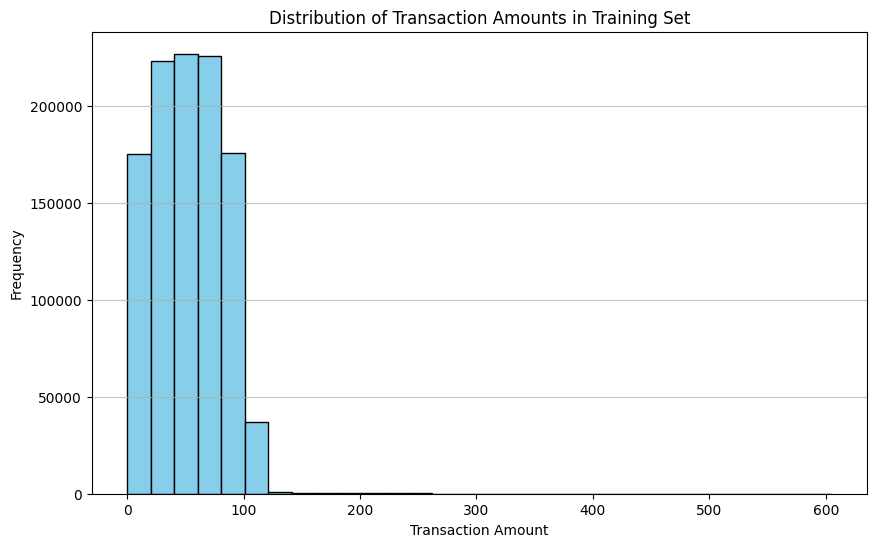

In [5]:
plt.figure(figsize=(10, 6))
plt.hist(transactions_train['TX_AMOUNT'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Transaction Amounts in Training Set')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

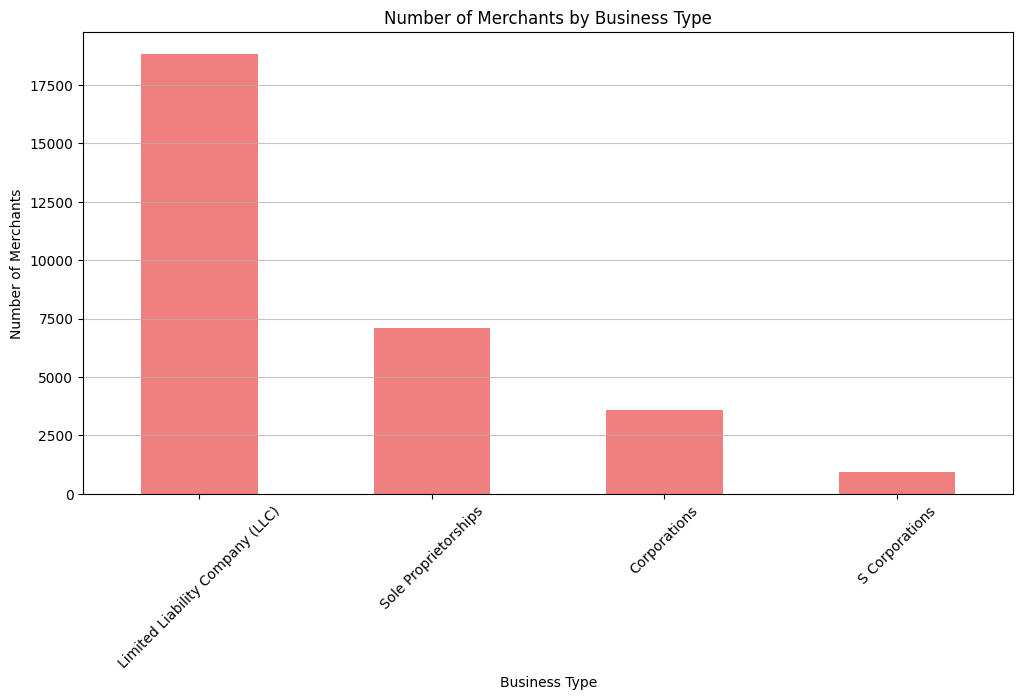

In [6]:
business_counts = merchants['BUSINESS_TYPE'].value_counts()
plt.figure(figsize=(12, 6))
business_counts.plot(kind='bar', color='lightcoral')
plt.title('Number of Merchants by Business Type')
plt.xlabel('Business Type')
plt.ylabel('Number of Merchants')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()

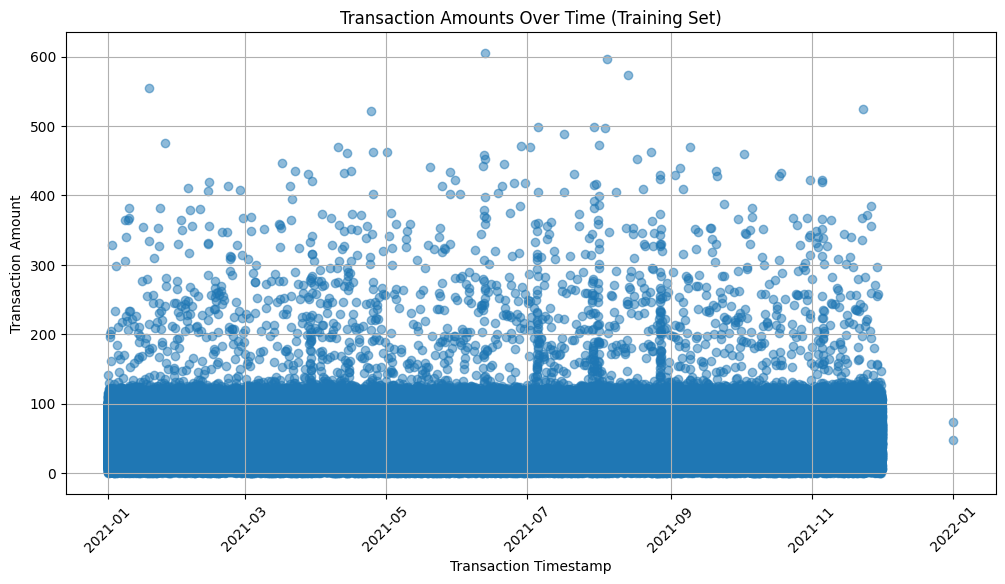

In [7]:
transactions_train['TX_TS'] = pd.to_datetime(transactions_train['TX_TS'], errors='coerce')
plt.figure(figsize=(12, 6))
plt.scatter(transactions_train['TX_TS'], transactions_train['TX_AMOUNT'], alpha=0.5)
plt.title('Transaction Amounts Over Time (Training Set)')
plt.xlabel('Transaction Timestamp')
plt.ylabel('Transaction Amount')
plt.xticks(rotation=45)
plt.grid()
plt.show()

<Figure size 1200x600 with 0 Axes>

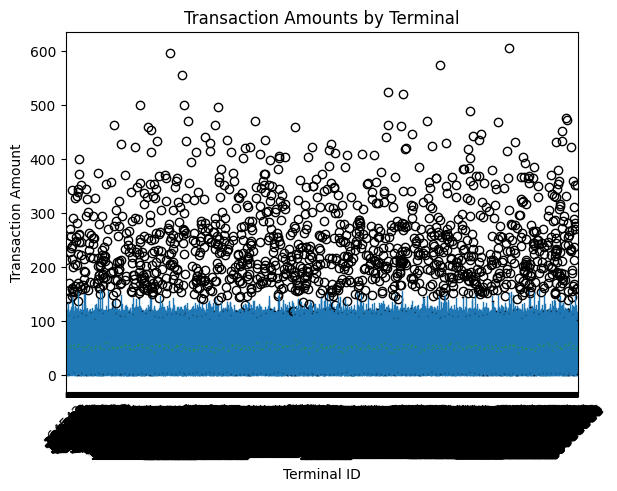

In [8]:
plt.figure(figsize=(12, 6))
transactions_train.boxplot(column='TX_AMOUNT', by='TERMINAL_ID', grid=False)
plt.title('Transaction Amounts by Terminal')
plt.suptitle('')
plt.xlabel('Terminal ID')
plt.ylabel('Transaction Amount')
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_1239/3786829266.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([transactions_train[transactions_train['TX_FRAUD'] == 0]['TX_AMOUNT'],


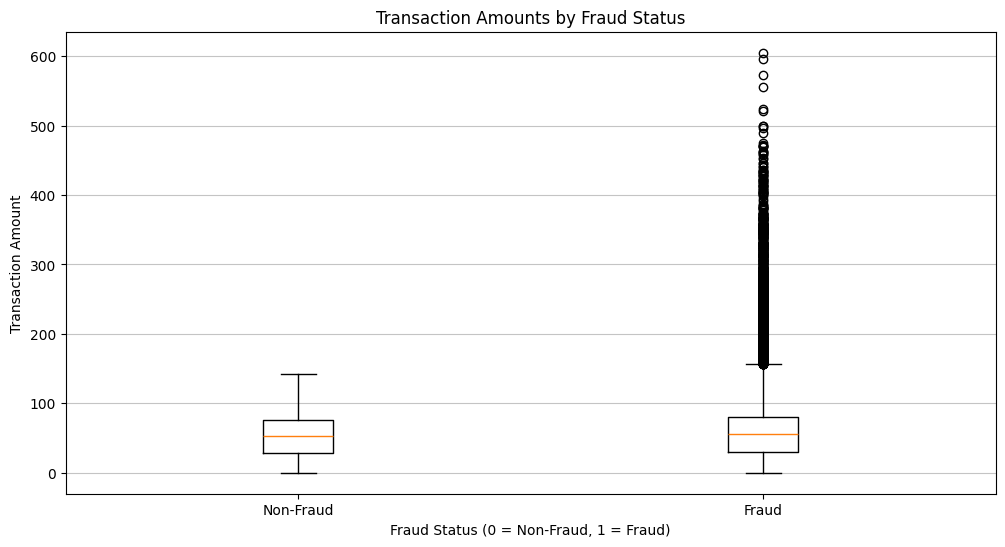

In [9]:
plt.figure(figsize=(12, 6))
plt.boxplot([transactions_train[transactions_train['TX_FRAUD'] == 0]['TX_AMOUNT'],
             transactions_train[transactions_train['TX_FRAUD'] == 1]['TX_AMOUNT']],
            labels=['Non-Fraud', 'Fraud'])
plt.title('Transaction Amounts by Fraud Status')
plt.xlabel('Fraud Status (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Transaction Amount')
plt.grid(axis='y', alpha=0.75)
plt.show()

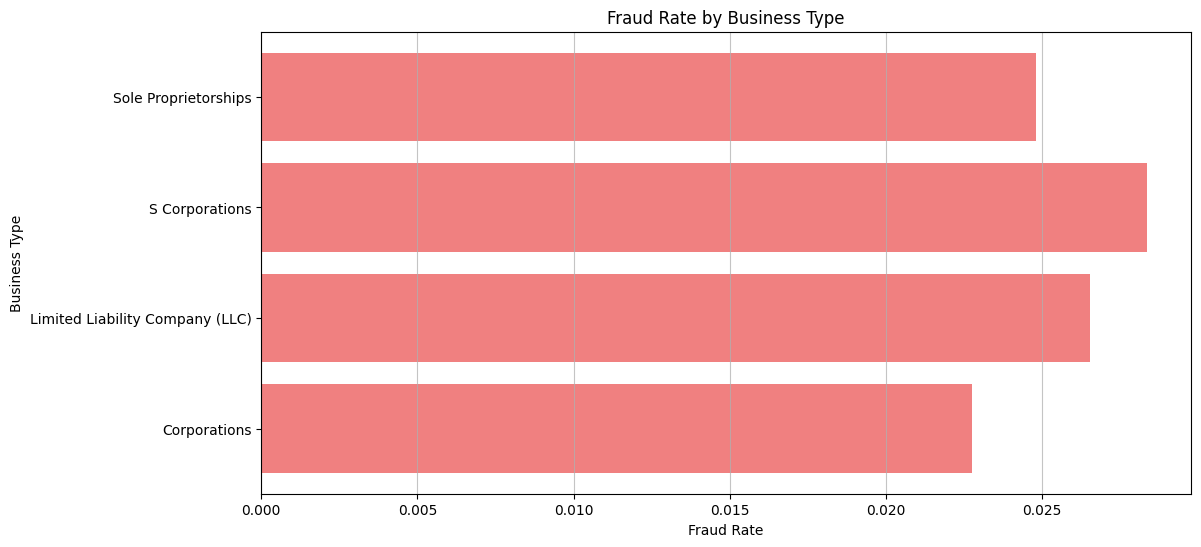

In [10]:
fraud_rate_by_business = transactions_train.groupby('MERCHANT_ID')['TX_FRAUD'].mean().reset_index()
fraud_rate_by_business = fraud_rate_by_business.merge(merchants[['MERCHANT_ID', 'BUSINESS_TYPE']], on='MERCHANT_ID')
fraud_rate_by_business = fraud_rate_by_business.groupby('BUSINESS_TYPE')['TX_FRAUD'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.barh(fraud_rate_by_business['BUSINESS_TYPE'], fraud_rate_by_business['TX_FRAUD'], color='lightcoral')
plt.title('Fraud Rate by Business Type')
plt.xlabel('Fraud Rate')
plt.ylabel('Business Type')
plt.grid(axis='x', alpha=0.75)
plt.show()

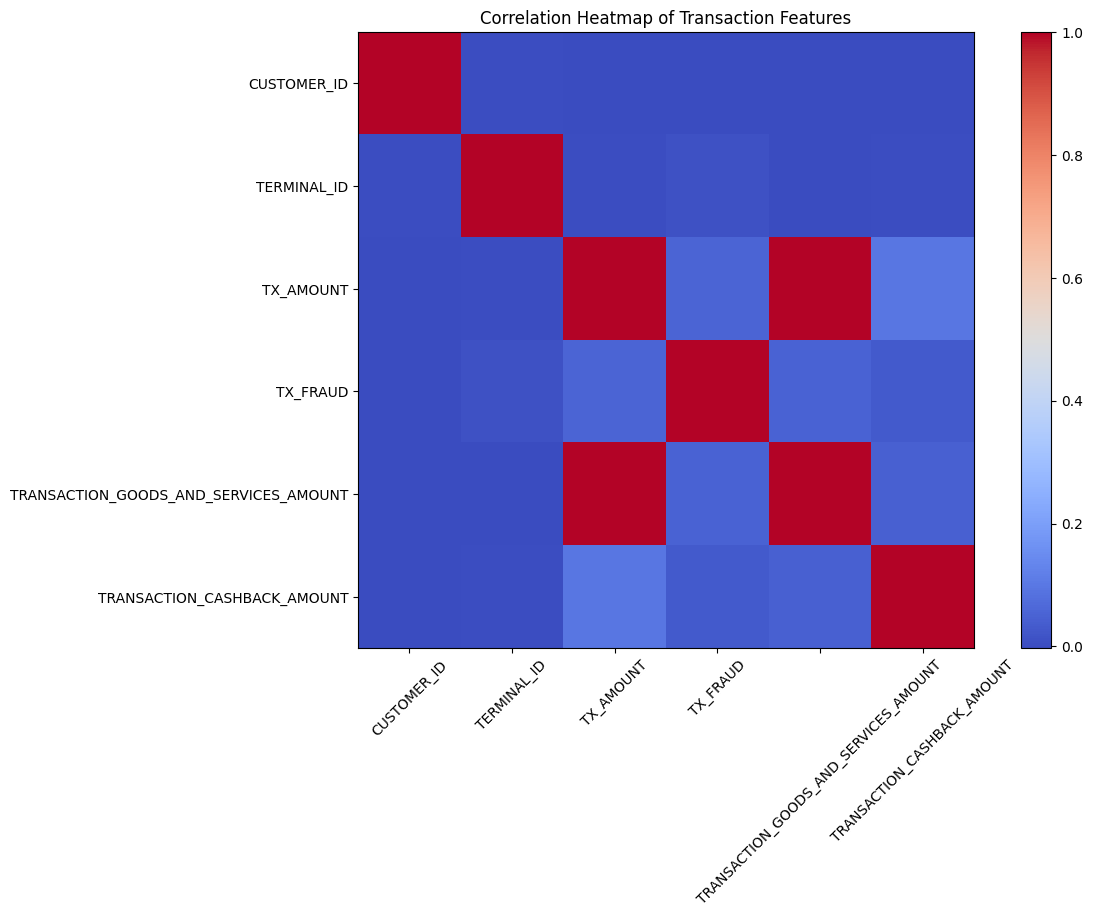

In [11]:
numeric_columns = transactions_train.select_dtypes(include=['number']).columns
correlation_matrix = transactions_train[numeric_columns].corr()

plt.figure(figsize=(12, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Correlation Heatmap of Transaction Features')
plt.show()

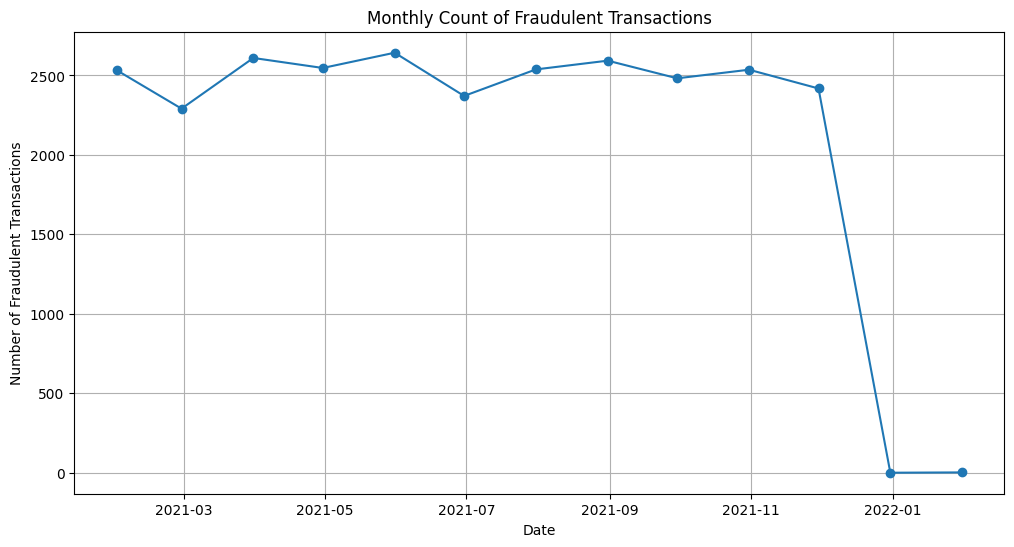

In [12]:
transactions_train['TX_TS'] = pd.to_datetime(transactions_train['TX_TS'])
monthly_fraud_counts = transactions_train.resample('ME', on='TX_TS')['TX_FRAUD'].sum()

plt.figure(figsize=(12, 6))
plt.plot(monthly_fraud_counts.index, monthly_fraud_counts.values, marker='o', linestyle='-')
plt.title('Monthly Count of Fraudulent Transactions')
plt.xlabel('Date')
plt.ylabel('Number of Fraudulent Transactions')
plt.grid()
plt.show()

### Merge dataframes

In [13]:
data = transactions_train.merge(customers, on='CUSTOMER_ID', how='left')
data = data.merge(terminals, on='TERMINAL_ID', how='left')
data = data.merge(merchants, on='MERCHANT_ID', how='left')

## Features

In [14]:
features = ['TX_AMOUNT', 'TRANSACTION_GOODS_AND_SERVICES_AMOUNT', 'TRANSACTION_CASHBACK_AMOUNT',
            'CARD_BRAND', 'TRANSACTION_TYPE', 'TRANSACTION_STATUS', 'TRANSACTION_CURRENCY',
            'CARD_COUNTRY_CODE', 'IS_RECURRING_TRANSACTION', 'CARDHOLDER_AUTH_METHOD',
            'BUSINESS_TYPE', 'MCC_CODE', 'OUTLET_TYPE', 'ANNUAL_TURNOVER_CARD', 'ANNUAL_TURNOVER',
            'AVERAGE_TICKET_SALE_AMOUNT', 'PAYMENT_PERCENTAGE_FACE_TO_FACE', 'PAYMENT_PERCENTAGE_ECOM',
            'PAYMENT_PERCENTAGE_MOTO', 'DEPOSIT_REQUIRED_PERCENTAGE', 'DEPOSIT_PERCENTAGE',
            'DELIVERY_SAME_DAYS_PERCENTAGE', 'DELIVERY_WEEK_ONE_PERCENTAGE', 'DELIVERY_WEEK_TWO_PERCENTAGE',
            'DELIVERY_OVER_TWO_WEEKS_PERCENTAGE']

### Prepare data

In [15]:
X = data[features].copy()
y = data['TX_FRAUD']

### Handle categorical variables

In [16]:
le = LabelEncoder()
for column in X.select_dtypes(include=['object']).columns:
    X.loc[:, column] = le.fit_transform(X[column].astype(str))

### Split data

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## RandomForestClassifier

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

### Predict with RandomForestClassifier

In [ ]:
rf_predictions = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]

## XGBoost 

In [ ]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

### Predict with XGBoost

In [ ]:
xgb_predictions = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]

### Functions

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_roc_curve(y_true, y_scores, title):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

def plot_feature_importance(model, features, title):
    feature_importance = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
    feature_importance = feature_importance.sort_values('importance', ascending=False).head(10)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

# RandomForest Results

In [ ]:
print(classification_report(y_test, rf_predictions))
plot_confusion_matrix(y_test, rf_predictions, "Random Forest Confusion Matrix")
plot_roc_curve(y_test, rf_proba, "Random Forest ROC Curve")
plot_feature_importance(rf_model, features, "Random Forest Feature Importance")

# XGBoost results

In [ ]:
print(classification_report(y_test, xgb_predictions))
plot_confusion_matrix(y_test, xgb_predictions, "XGBoost Confusion Matrix")
plot_roc_curve(y_test, xgb_proba, "XGBoost ROC Curve")
plot_feature_importance(xgb_model, features, "XGBoost Feature Importance")